In [ ]:
import time
import torch
import config
from util import train, evaluate

### Preface

Хотим обучить классификацию текстов (в данном примере на датасете [AG News](https://paperswithcode.com/dataset/ag-news), но можно использовать другие датасеты из HF, если соответствующе поправить конфиг), используя разные способы токенизации. Обучим стандартные подходы в виде посимвольной токенизации и bpe-токенизации, а также посмотрим на новый метод Gradient-based subword tokenization.  
В качестве базовой архитектуры для классификации используется небольшой кастомный набор, которые вкратце выглядит так: `TokenEncoder(Embedding+Positional или GBST) + Conv1d + TransformerEncoder + Linear(->n_classes)`. Вы также можете использовать свою архитектуру, дописав её в `models.py` и создав свой сетап в `configs`.

! Стоит заметить, что модели необязательно доведены до сходимости, и предельное качество может быть другим, однако уже по проведенному обучению мы можем судить о качестве в рамках конкретного Computational Budget и о скорости сходимости.

### 1. Chars

Токенизируем посимвольно, эмбеддинги токенов получаем как lookup table + positional encoding

In [137]:
text_encoder, model, train_dl, valid_dl = config.get_chars_setup()

  0%|          | 0/2 [00:00<?, ?it/s]

In [138]:
%%time
n_epochs = 10

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, n_epochs + 1):
    epoch_start_time = time.time()
    train(model, optimizer, criterion, train_dl, epoch)
    accu_val = evaluate(model, criterion, valid_dl)
    
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch, time.time() - epoch_start_time, accu_val))
    print('-' * 59)

-----------------------------------------------------------
| end of epoch   1 | time: 64.68s | valid accuracy    0.569 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time: 63.99s | valid accuracy    0.682 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time: 64.56s | valid accuracy    0.752 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time: 63.91s | valid accuracy    0.773 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time: 64.70s | valid accuracy    0.781 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time: 64.90s |

### 2. BPE

Токенизируем с помощью предобученной sentencepiece (bpe), эмбеддинги токенов получаем как lookup table + positional encoding

In [139]:
bpe_text_encoder, bpe_model, bpe_train_dl, bpe_valid_dl = config.get_bpe_setup()

  0%|          | 0/2 [00:00<?, ?it/s]

In [140]:
%%time
n_epochs = 10

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bpe_model.parameters(), lr=1e-3)

for epoch in range(1, n_epochs + 1):
    epoch_start_time = time.time()
    train(bpe_model, optimizer, criterion, bpe_train_dl, epoch)
    accu_val = evaluate(bpe_model, criterion, bpe_valid_dl)
    
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch, time.time() - epoch_start_time, accu_val))
    print('-' * 59)

-----------------------------------------------------------
| end of epoch   1 | time: 49.74s | valid accuracy    0.735 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time: 49.07s | valid accuracy    0.787 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time: 50.11s | valid accuracy    0.816 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time: 48.98s | valid accuracy    0.829 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time: 52.00s | valid accuracy    0.838 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time: 57.33s |

### 3. GBST
Токенизируем посимвольно, эмбеддинги токенов получаем в процессе Gradient-based Subword Tokenization

In [141]:
gbst_text_encoder, gbst_model, gbst_train_dl, gbst_valid_dl = config.get_gbst_setup()

  0%|          | 0/2 [00:00<?, ?it/s]

In [158]:
n_epochs = 10

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gbst_model.parameters(), lr=1e-3)

for epoch in range(1, n_epochs + 1):
    epoch_start_time = time.time()
    train(gbst_model, optimizer, criterion, gbst_train_dl, epoch)
    accu_val = evaluate(gbst_model, criterion, gbst_valid_dl)
    
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch, time.time() - epoch_start_time, accu_val))
    print('-' * 59)
    
torch.save(gbst_model.state_dict(), 'gbst.pth')

-----------------------------------------------------------
| end of epoch   1 | time: 44.15s | valid accuracy    0.537 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time: 43.83s | valid accuracy    0.633 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time: 44.27s | valid accuracy    0.730 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time: 43.62s | valid accuracy    0.764 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time: 44.23s | valid accuracy    0.772 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time: 44.57s |

### 4. Картинки про GBST

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['font.size'] = 10
sns.set_style('darkgrid')

In [148]:
gbst_text_encoder, gbst_model, gbst_train_dl, gbst_valid_dl = config.get_gbst_setup()
gbst_model.load_state_dict(torch.load('gbst.pth'))

  0%|          | 0/2 [00:00<?, ?it/s]

<All keys matched successfully>

#### Проекции начальных эмбеддингов букв внутри GBST

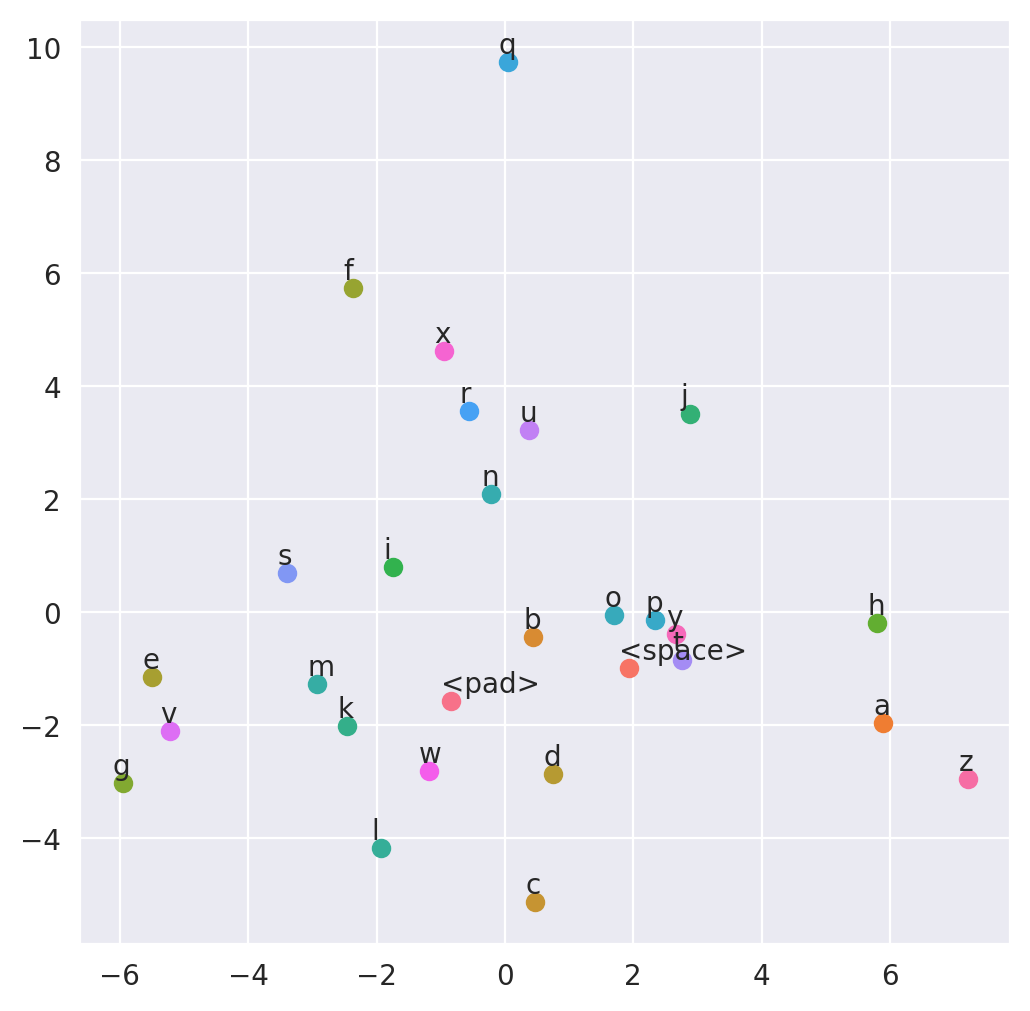

In [160]:
from sklearn.decomposition import PCA
reducer = PCA(n_components=2)
letter_embeddings = gbst_model.token_encoder.gbst.token_emb.weight.detach().cpu().numpy()
reduced_embeddings = reducer.fit_transform(letter_embeddings)

palette = sns.color_palette('husl', n_colors=len(gbst_text_encoder.char2ind))  
for char, ind in text_encoder.char2ind.items():
    xy = reduced_embeddings[ind]
    plt.scatter(*xy, color=palette[ind])
    ch = char if ind > 1 else ['<pad>', '<space>'][ind]
    plt.annotate(ch, xy=xy, xytext=xy+[-0.15,0.15])

#### Скоры блоков различной длины для каждого символа

In [161]:
def get_sample(text):
    return gbst_valid_dl.collate_fn([{'text': text, 'label': 0}])

sample_batch = get_sample('on subword tokenization')
sample_batch['text'][0]

'on subword tokenization'

In [162]:
_, _, scores = gbst_model.token_encoder.gbst(sample_batch['text_padded'])
scores = scores.squeeze(0).squeeze(-1).detach().cpu().numpy().T

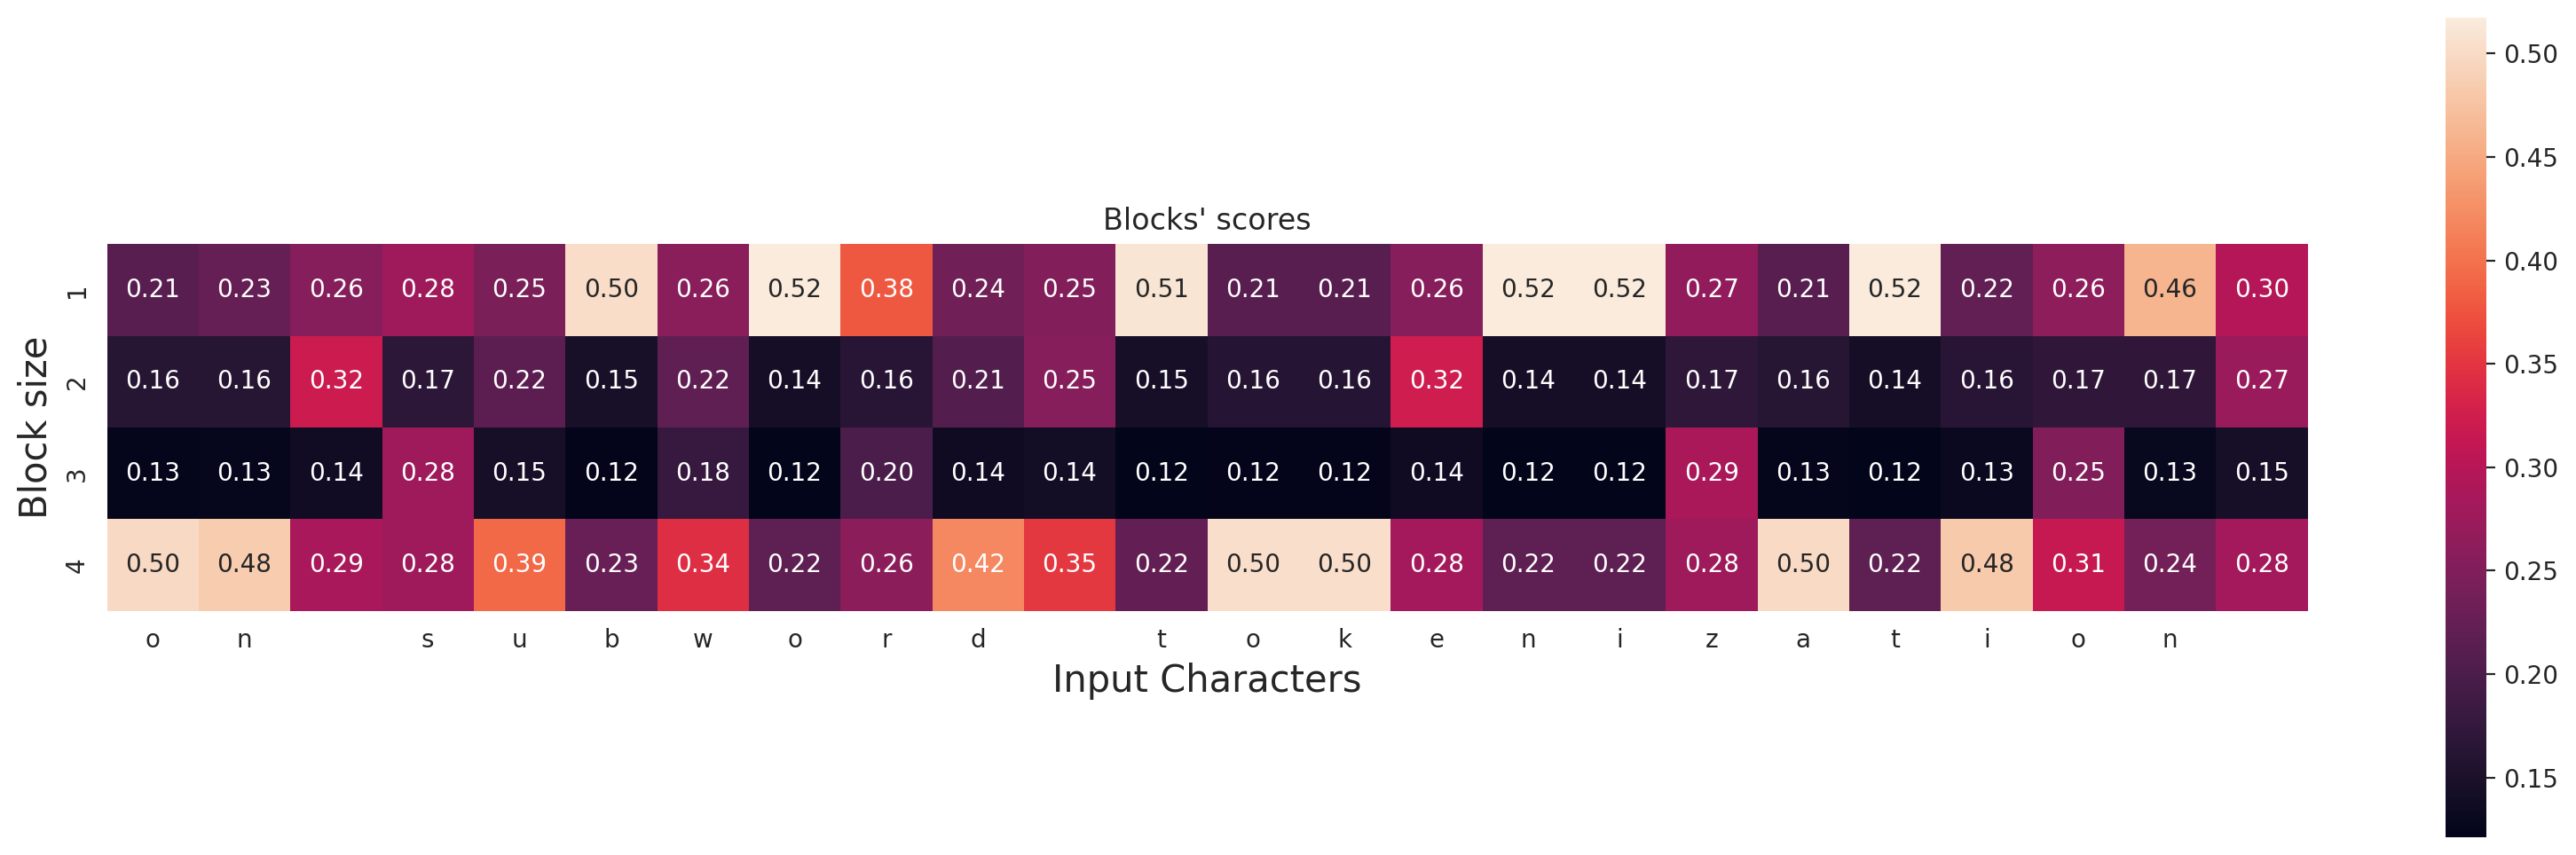

In [163]:
plt.figure(figsize=(20, 6))
sns.heatmap(scores, annot=True, fmt=".2f", xticklabels=sample_batch['text'][0], yticklabels=range(1, 5), square=True)
plt.xlabel('Input Characters', fontsize=15)
plt.ylabel('Block size', fontsize=15)
_ = plt.title('Blocks\' scores')